In [1]:
# 1. Imports & Global configuration 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from pathlib import Path
from requests import get
from functools import wraps
from collections import defaultdict

DATA_DIR = Path("data")
DATA_DIR.mkdir(parents=True, exist_ok=True)

RAW_DIR = DATA_DIR / "raw"
RAW_DIR.mkdir(parents=True, exist_ok=True)

CALENDAR_YMD = "20240614"
LISTINGS_YMD = "20250615"
CITY = "London"

HOST = "https://orca.casa.ucl.ac.uk"
ORCA_PATH = "~jreades/data"

# ORCA filenames
CALENDAR_FILE = RAW_DIR / f"{CALENDAR_YMD}-{CITY}-calendar.csv.gz"
LISTINGS_FILE = RAW_DIR / f"{LISTINGS_YMD}-{CITY}-listings.csv.gz"

In [2]:
# 2. cache helper
def check_cache(f):
    @wraps(f)
    def wrapper(src: str, dst_dir: Path, min_size: int = 100) -> Path:
        src0 = src.split("?")[0]
        fn = Path(src0).name
        dst = dst_dir / fn

        if dst.is_file() and dst.stat().st_size > min_size:
            print(f"+ {dst} found locally!")
            return dst
        else:
            print(f"+ {dst} not found, downloading!")
            return f(src, dst)
    return wrapper


@check_cache
def cache_data(src: str, dst: Path) -> Path:
    if not dst.parent.exists():
        dst.parent.mkdir(parents=True, exist_ok=True)

    with dst.open("wb") as f:
        r = get(src)
        r.raise_for_status()
        f.write(r.content)

    print("+ Done downloading.")
    return dst.resolve()

In [3]:
# 3. download/cache ORCA data
listings_url = f"{HOST}/{ORCA_PATH}/{LISTINGS_FILE.name}"
calendar_url = f"{HOST}/{ORCA_PATH}/{CALENDAR_FILE.name}"

listings_path = cache_data(listings_url, RAW_DIR)
calendar_path = cache_data(calendar_url, RAW_DIR)

+ data/raw/20250615-London-listings.csv.gz found locally!
+ data/raw/20240614-London-calendar.csv.gz found locally!


In [4]:
# 4.read calendar by chunks
CHUNK_SIZE  = 200_000

def summarise_calendar_streaming(
    path: Path,
    chunk_size: int = CHUNK_SIZE,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-14",
) -> pd.DataFrame:

    agg = {}  # {listing_id: [occupied_nights, total_nights]}

    for chunk in pd.read_csv(
        path,
        chunksize=chunk_size,
        usecols=["listing_id", "available", "date"],
        low_memory=False
    ):

        chunk["date"] = pd.to_datetime(chunk["date"], errors="coerce")
        chunk = chunk.dropna(subset=["date"])

        mask = (chunk["date"] >= start_date) & (chunk["date"] < end_date)
        chunk = chunk.loc[mask]
        if chunk.empty:
            continue

        chunk["is_occupied"] = (
            chunk["available"].astype(str).str.lower() == "f"
        )

        grouped = (
            chunk
            .groupby("listing_id")["is_occupied"]
            .agg(["sum", "count"])
            .reset_index()
        )

        for _, row in grouped.iterrows():
            lid = int(row["listing_id"])
            occ = int(row["sum"])
            tot = int(row["count"])

            if lid not in agg:
                agg[lid] = [0, 0]

            agg[lid][0] += occ
            agg[lid][1] += tot

    summary = (
        pd.DataFrame.from_dict(
            agg,
            orient="index",
            columns=["occupied_nights", "total_nights"]
        )
        .reset_index()
        .rename(columns={"index": "listing_id"})
    )

    summary["available_nights"] = (
        summary["total_nights"] - summary["occupied_nights"]
    )
    summary["occupancy_rate"] = (
        summary["occupied_nights"] / summary["total_nights"]
    )

    return summary
occ_summary = summarise_calendar_streaming(CALENDAR_FILE)
print(occ_summary.shape)
print(occ_summary.head())

(93480, 5)
   listing_id  occupied_nights  total_nights  available_nights  occupancy_rate
0       13913               34           365               331        0.093151
1       15400              202           365               163        0.553425
2       17402              100           364               264        0.274725
3       24328              364           364                 0        1.000000
4       33332                0           365               365        0.000000


In [5]:
# 5. read listings
listings = pd.read_csv(listings_path)

print("Listings:", listings.shape)

Listings: (96651, 79)


In [6]:
# 6. group-provided borough data (local)
RENT_EXCEL_PATH = DATA_DIR / "borough_rent_2024_07_2025_06.xlsx"
STOCK_CSV_PATH  = DATA_DIR / "social-landlord-housing-stock-borough.csv"

if not RENT_EXCEL_PATH.exists():
    raise FileNotFoundError(f"Missing file: {RENT_EXCEL_PATH.resolve()}")
if not STOCK_CSV_PATH.exists():
    raise FileNotFoundError(f"Missing file: {STOCK_CSV_PATH.resolve()}")

rent  = pd.read_excel(RENT_EXCEL_PATH)
stock = pd.read_csv(STOCK_CSV_PATH)

print("Rent:", rent.shape)
print("Stock:", stock.shape)

Rent: (27, 1)
Stock: (46, 31)


In [7]:
# 7. thresholds / constants
VIOLATION_THRESHOLD        = 90
COMMERCIAL_AVAIL_THRESHOLD = 60
HOTEL_LIKE_OCC_THRESHOLD   = 180

CHUNK_SIZE  = 200_000
BOROUGH_COL = "neighbourhood_cleansed"

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 12
plt.rcParams["axes.labelsize"] = 10

In [10]:
# 8. Core wrangling helpers (used by Q1/Q2/Q3)
def load_listings(path: Path) -> pd.DataFrame:
    cols_in_file = pd.read_csv(path, nrows=0).columns.tolist()

    desired_cols = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price",
    ]
    usecols = [c for c in desired_cols if c in cols_in_file]

    df = pd.read_csv(path, usecols=usecols, low_memory=False)

    if "price" in df.columns:
        price_str = df["price"].astype(str).str.replace(r"[^\d.]", "", regex=True)
        df["price_clean"] = pd.to_numeric(price_str, errors="coerce")
    else:
        df["price_clean"] = np.nan

    return df


def merge_calendar_listings(occ_summary: pd.DataFrame, listings: pd.DataFrame) -> pd.DataFrame:
    cols_to_keep = [
        "id", "host_id", "room_type",
        "neighbourhood_cleansed", "neighbourhood_group_cleansed",
        "latitude", "longitude",
        "number_of_reviews", "price_clean",
    ]
    existing_cols = [c for c in cols_to_keep if c in listings.columns]

    merged = occ_summary.merge(
        listings[existing_cols].drop_duplicates(subset="id"),
        left_on="listing_id",
        right_on="id",
        how="left",
    )
    return merged


def add_core_flags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["is_entire_home"] = df["room_type"].eq("Entire home/apt")

    if not {"occupied_nights", "available_nights"}.issubset(df.columns):
        raise ValueError("缺少 occupied_nights 或 available_nights 列。")

    df["violates_90day"] = df["occupied_nights"] > VIOLATION_THRESHOLD
    df["commercial_STR"] = df["available_nights"] > COMMERCIAL_AVAIL_THRESHOLD
    df["hotel_like"]     = df["occupied_nights"] > HOTEL_LIKE_OCC_THRESHOLD

    df["legal_but_commercial"] = (~df["violates_90day"]) & df["commercial_STR"]
    return df


def prepare_merged(
    calendar_path: Path,
    listings_path: Path,
    start_date: str = "2024-06-14",
    end_date: str   = "2025-06-15",
) -> pd.DataFrame:
    print(f"=== Core Step: Summarising calendar {start_date} ~ {end_date} ===")
    occ_summary = summarise_calendar_streaming(
        calendar_path,
        chunk_size=CHUNK_SIZE,
        start_date=start_date,
        end_date=end_date,
    )
    print("  Listings with calendar data:", len(occ_summary))

    print("=== Core Step: Loading listings and merging ===")
    listings = load_listings(listings_path)
    merged = merge_calendar_listings(occ_summary, listings)
    merged = add_core_flags(merged)

    del occ_summary
    del listings

    print("  Total listings in merged:", merged["listing_id"].nunique())
    print("  Columns:", list(merged.columns))
    return merged


In [11]:
# 9. read calendar&listings，merge, flag
merged = prepare_merged(
    calendar_path=calendar_path,
    listings_path=listings_path
)

=== Core Step: Summarising calendar 2024-06-15 ~ 2025-06-14 ===
  Listings with calendar data: 93480
=== Core Step: Loading listings and merging ===
  Total listings in merged: 93480
  Columns: ['listing_id', 'occupied_nights', 'total_nights', 'available_nights', 'occupancy_rate', 'id', 'host_id', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'number_of_reviews', 'price_clean', 'is_entire_home', 'violates_90day', 'commercial_STR', 'hotel_like', 'legal_but_commercial']


In [12]:
# 10. 
print("merged shape:", merged.shape)
print("columns:", list(merged.columns)[:30], "...")

need_cols = ["listing_id", "occupied_nights", "available_nights", "room_type",
             "is_entire_home", "violates_90day", "commercial_STR", BOROUGH_COL]
for c in need_cols:
    print(f"{c}: ", "OK" if c in merged.columns else "MISSING")

if "room_type" in merged.columns:
    print("\nroom_type value counts (top 10):")
    print(merged["room_type"].value_counts(dropna=False).head(10))

if "is_entire_home" in merged.columns:
    print("\nis_entire_home counts:")
    print(merged["is_entire_home"].value_counts(dropna=False))

if BOROUGH_COL in merged.columns:
    print(f"\n{BOROUGH_COL} missing rate:", merged[BOROUGH_COL].isna().mean())
    print(f"{BOROUGH_COL} top 10:")
    print(merged[BOROUGH_COL].value_counts(dropna=False).head(10))


merged shape: (93480, 19)
columns: ['listing_id', 'occupied_nights', 'total_nights', 'available_nights', 'occupancy_rate', 'id', 'host_id', 'room_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude', 'longitude', 'number_of_reviews', 'price_clean', 'is_entire_home', 'violates_90day', 'commercial_STR', 'hotel_like', 'legal_but_commercial'] ...
listing_id:  OK
occupied_nights:  OK
available_nights:  OK
room_type:  OK
is_entire_home:  OK
violates_90day:  OK
commercial_STR:  OK
neighbourhood_cleansed:  OK

room_type value counts (top 10):
room_type
Entire home/apt    40112
NaN                27929
Private room       25250
Hotel room           108
Shared room           81
Name: count, dtype: int64

is_entire_home counts:
is_entire_home
False    53368
True     40112
Name: count, dtype: int64

neighbourhood_cleansed missing rate: 0.29876979032948225
neighbourhood_cleansed top 10:
neighbourhood_cleansed
NaN                       27929
Westminster                6849
Towe

In [13]:
# 11.Policy

# entire-home
def _unique_entire_listings(df: pd.DataFrame) -> pd.DataFrame:
    out = df[df["is_entire_home"]].copy()
    out = out.drop_duplicates(subset="listing_id")
    return out


def citywide_violation_stats(df: pd.DataFrame) -> dict:
    entire = _unique_entire_listings(df)
    total_entire = entire["listing_id"].nunique()

    n_viol = int(entire["violates_90day"].sum())
    share_viol = n_viol / total_entire if total_entire > 0 else np.nan

    n_comm = int(entire["commercial_STR"].sum())
    share_comm = n_comm / total_entire if total_entire > 0 else np.nan

    overlap = int((entire["violates_90day"] & entire["commercial_STR"]).sum())
    overlap_rate = overlap / n_viol if n_viol > 0 else np.nan

    return {
        "total_entire_homes": int(total_entire),
        "n_violates_90day": int(n_viol),
        "share_violates_90day": share_viol,
        "n_commercial_entire": int(n_comm),
        "share_commercial_entire": share_comm,
        "overlap_count": int(overlap),
        "overlap_rate_within_violations": overlap_rate,
    }

def neighbourhood_violation_stats(df: pd.DataFrame) -> pd.DataFrame:
    entire = _unique_entire_listings(df)
    entire = entire.dropna(subset=[BOROUGH_COL]).copy()

    grouped = (
        entire
        .groupby(BOROUGH_COL)
        .agg(
            n_entire=("listing_id", "nunique"),
            n_violations=("violates_90day", "sum"),
            n_commercial=("commercial_STR", "sum"),
        )
        .reset_index()
        .rename(columns={BOROUGH_COL: "borough"})
    )

    grouped["share_violations"] = grouped["n_violations"] / grouped["n_entire"]
    grouped["share_commercial"] = grouped["n_commercial"] / grouped["n_entire"]

    return grouped

# Figure 1 
def plot_occupied_histogram(df: pd.DataFrame) -> None:
    entire = _unique_entire_listings(df)

    plt.figure()
    plt.hist(entire["occupied_nights"].dropna(), bins=30)
    plt.axvline(
        VIOLATION_THRESHOLD,
        color="red",
        linestyle="--",
        label="90-night limit"
    )
    plt.xlabel("Occupied nights (entire homes)")
    plt.ylabel("Number of listings")
    plt.title("Distribution of occupied nights (entire homes)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Figure 2
def plot_top_violation_areas(neigh_stats: pd.DataFrame, top_n: int = 20) -> None:
    df = neigh_stats.sort_values("share_violations", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(df["borough"], df["share_violations"])
    plt.gca().invert_yaxis()
    plt.xlabel("Share of entire homes violating 90-day rule")
    plt.ylabel("Borough")
    plt.title(f"Top {top_n} boroughs by 90-day rule violation rate")
    plt.tight_layout()
    plt.show()


# Figure 3 
def plot_share_commercial_vs_violations(neigh_stats: pd.DataFrame) -> None:
    df = neigh_stats.dropna(subset=["share_violations", "share_commercial"]).copy()
    if df.empty:
        print("No borough data，skip offset points.")
        return

    plt.figure(figsize=(7, 6))
    plt.scatter(df["share_violations"], df["share_commercial"])

    for _, row in df.iterrows():
        plt.annotate(
            row["borough"],
            (row["share_violations"], row["share_commercial"]),
            fontsize=8,
            xytext=(3, 3),
            textcoords="offset points",
        )

    plt.xlabel("Share of 90-day violations (entire homes)")
    plt.ylabel("Share of commercial STR (entire homes)")
    plt.title("Commercial STR vs 90-day violations by borough")
    plt.tight_layout()
    plt.show()


def run_policy_from_merged(merged: pd.DataFrame) -> dict:
    """
    Policy analysis (restricted):
      - City-level stats
      - Borough-level stats
      - Figure 1: occupied nights histogram
      - Figure 2: top violation boroughs
      - Figure 3: commercial vs violations
    """
    print("=== Policy: city-level stats ===")
    city_stats = citywide_violation_stats(merged)
    for k, v in city_stats.items():
        if isinstance(v, float):
            if "share" in k or "rate" in k:
                print(f"  {k}: {v:.2%}")
            else:
                print(f"  {k}: {v:.2f}")
        else:
            print(f"  {k}: {v}")

    print("\n=== Policy: borough-level stats ===")
    neigh_stats = neighbourhood_violation_stats(merged)
    print(neigh_stats.head())

    print("\n=== Figure 1 ===")
    plot_occupied_histogram(merged)

    print("\n=== Figure 2 ===")
    plot_top_violation_areas(neigh_stats, top_n=20)

    print("\n=== Figure 3 ===")
    plot_share_commercial_vs_violations(neigh_stats)

    print("\n=== Policy analysis done. ===")
    return {
        "city_stats": city_stats,
        "borough_stats": neigh_stats
    }


=== Policy: city-level stats ===
  total_entire_homes: 40112
  n_violates_90day: 33369
  share_violates_90day: 83.19%
  n_commercial_entire: 20329
  share_commercial_entire: 50.68%
  overlap_count: 13586
  overlap_rate_within_violations: 40.71%

=== Policy: borough-level stats ===
                borough  n_entire  n_violations  n_commercial  \
0  Barking and Dagenham       186           132           125   
1                Barnet       949           707           620   
2                Bexley       160           100           124   
3                 Brent      1054           882           580   
4               Bromley       303           239           183   

   share_violations  share_commercial  
0          0.709677          0.672043  
1          0.744995          0.653319  
2          0.625000          0.775000  
3          0.836812          0.550285  
4          0.788779          0.603960  

=== Figure 1 ===


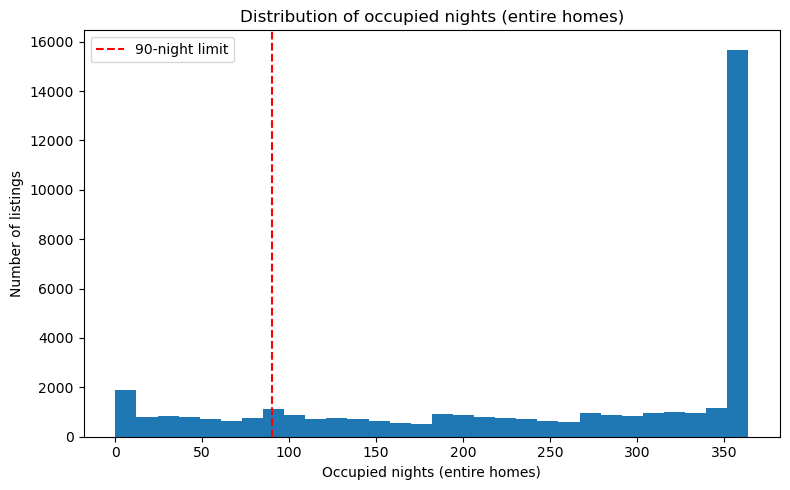


=== Figure 2 ===


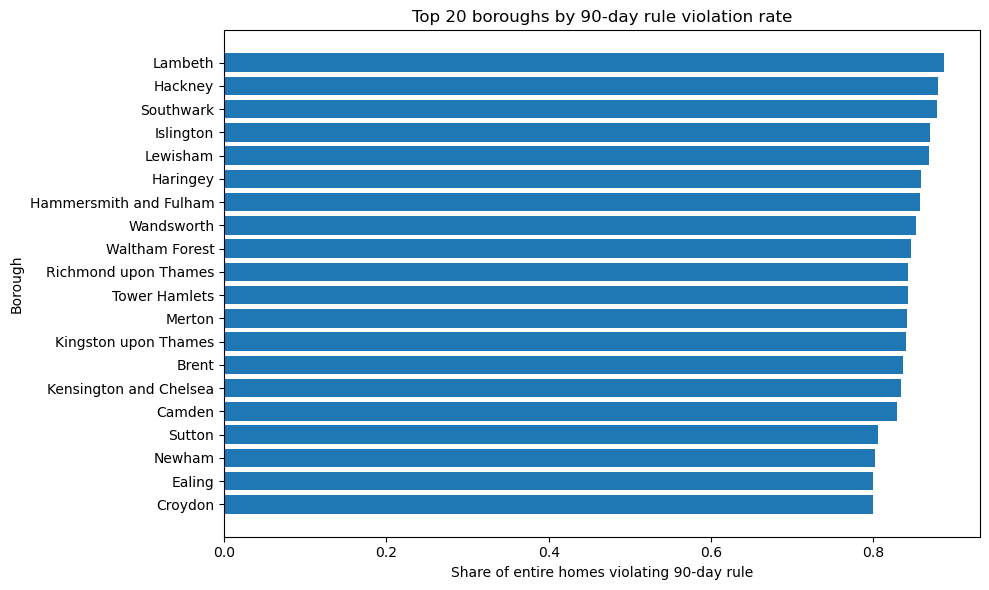


=== Figure 3 ===


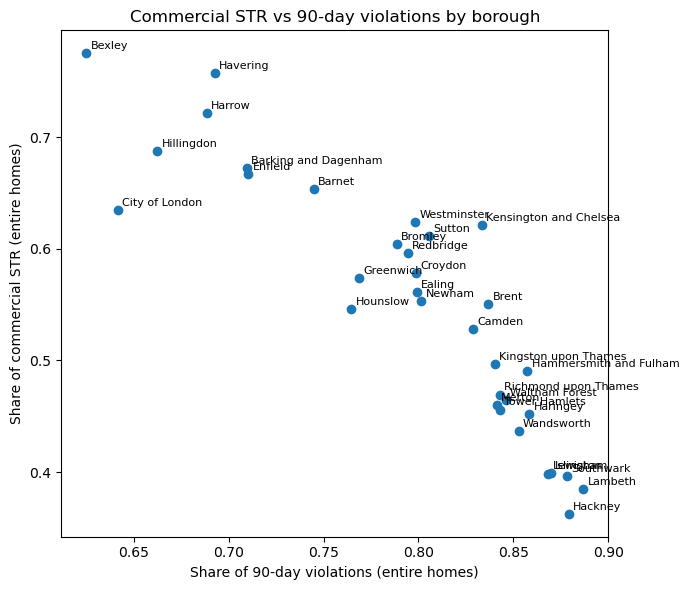


=== Policy analysis done (Figures 1–3 only). ===


In [14]:
# 12 
results_policy = run_policy_from_merged(merged)